In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import pandas as pd
import numpy as np

import re
import string
import sys  
# !{sys.executable} -m pip install contractions
import contractions

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import wordnet


[nltk_data] Downloading package stopwords to /home/lan-
[nltk_data]     chu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/lan-chu/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/lan-chu/nltk_data...


In [3]:
raw_data = pd.read_csv("./imdb_dataset.csv")
raw_x = raw_data.iloc[:, 0]
raw_y = raw_data.iloc[:, 1]

In [4]:
raw_data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [5]:
raw_x

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 50000, dtype: object

In [6]:


def Negation(sentence):	
  '''
  Input: Tokenized sentence (List of words)
  Output: Tokenized sentence with negation handled (List of words)
  '''
  temp = int(0)
  for i in range(len(sentence)):
      if sentence[i-1] in ['not',"n't"]:
          antonyms = []
          for syn in wordnet.synsets(sentence[i]):
              syns = wordnet.synsets(sentence[i])
              w1 = syns[0].name()
              temp = 0
              for l in syn.lemmas():
                  if l.antonyms():
                      antonyms.append(l.antonyms()[0].name())
              max_dissimilarity = 0
              for ant in antonyms:
                  syns = wordnet.synsets(ant)
                  w2 = syns[0].name()
                  syns = wordnet.synsets(sentence[i])
                  w1 = syns[0].name()
                  word1 = wordnet.synset(w1)
                  word2 = wordnet.synset(w2)
                  if isinstance(word1.wup_similarity(word2), float) or isinstance(word1.wup_similarity(word2), int):
                      temp = 1 - word1.wup_similarity(word2)
                  if temp>max_dissimilarity:
                      max_dissimilarity = temp
                      antonym_max = ant
                      sentence[i] = antonym_max
                      sentence[i-1] = ''
  while '' in sentence:
      sentence.remove('')
  return sentence

In [7]:
stemmer = PorterStemmer()
stopwords_english = stopwords.words('english')
stopwords_english.remove('not')
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                              reduce_len=True)

def process_review(text):
  text = text.lower()
  text = re.sub('<.*?>+', ' ', text)
  text = re.sub(r'https?:\/\/.*[\r\n]*', ' ', text)
  text = re.sub(r'[0-9]', ' ', text) # removing number 
  text = re.sub('\n', ' ', text)
  text = contractions.fix(text)
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  
  tokens = tokenizer.tokenize(text)
  tokens = Negation(tokens)
  
  clean_text = []
  for token in tokens:
        if (token not in stopwords_english):
            stem_word = stemmer.stem(token)
            clean_text.append(stem_word)
  return ' '.join(clean_text)

In [8]:
print(process_review("I dont like this movie"))

dislik movi


In [9]:
clean_data = raw_x.apply(process_review)


In [10]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3))

In [11]:
transformed = vectorizer.fit_transform(clean_data)

In [12]:
print(len(vectorizer.get_feature_names_out()))

7961333


In [13]:
def k_fold_evaluate(transformed, raw_y):
  kf = KFold(n_splits=5)
  accs = []
  pres = []
  recs = []
  f1s = []
  cons = []
  for trains_ids, test_ids in kf.split(transformed, raw_y):
    train_x, test_x, train_y, test_y = transformed[trains_ids], transformed[test_ids], raw_y[trains_ids], raw_y[test_ids]
    clf = MultinomialNB().fit(train_x, train_y)
    predicted = clf.predict(test_x)
    acc = accuracy_score(predicted, test_y)
    precision = precision_score(predicted, test_y, average="weighted")
    recall = recall_score(predicted, test_y, average="weighted")
    f1 = f1_score(predicted, test_y, average="weighted")
    con = confusion_matrix(predicted, test_y)
    accs.append(acc)
    pres.append(precision)
    recs.append(recall)
    f1s.append(f1)
    cons.append(con)
    model = clf
  return model, accs, pres, recs, f1s, cons

In [14]:
train_x, test_x, train_y, test_y = train_test_split(transformed, raw_y, train_size=0.8)
model = MultinomialNB().fit(train_x, train_y)

In [15]:
def evaluate(model, test_x, test_y):
  predicted = model.predict(test_x)
  conf_matrix = confusion_matrix(test_y, predicted)
  
  print('Classification Report:\n', classification_report(test_y, predicted, digits=4))
  print('Confusion Matrix:\n')
  ConfusionMatrixDisplay(conf_matrix).plot()

Classification Report:
               precision    recall  f1-score   support

    negative     0.8895    0.8934    0.8915      5066
    positive     0.8901    0.8861    0.8881      4934

    accuracy                         0.8898     10000
   macro avg     0.8898    0.8898    0.8898     10000
weighted avg     0.8898    0.8898    0.8898     10000

Confusion Matrix:



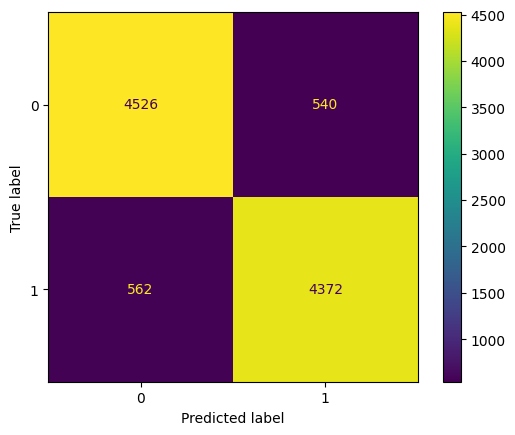

In [17]:
evaluate(model, test_x, test_y)

In [18]:
model.predict(vectorizer.transform([process_review("This movie is not good")]))

array(['negative'], dtype='<U8')

In [21]:
from joblib import dump, load

In [23]:
dump(model, './saved/movie_review_sa_v1.joblib') 
dump(vectorizer, './saved/tfidf_vectorizer.joblib')

['./saved/tfidf_vectorizer.joblib']

In [24]:
loadedModel = load('./saved/movie_review_sa_v1.joblib')
loadedVectorizer = load('./saved/tfidf_vectorizer.joblib')

In [25]:
loadedModel.predict(loadedVectorizer.transform([process_review("This movie is not good")]))

array(['negative'], dtype='<U8')